<a href="https://colab.research.google.com/github/cesar-ramosh/Gobernanzas-de-datos/blob/main/Laboral_mes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="red">**ETL DATOS MENSUALES MERCADO LABORAL**</font>

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objects as go

# Paquetes Python
from google.colab import drive
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import warnings
import locale
import plotly.figure_factory as ff
import plotly.offline as py
import datetime as dt
import plotly.io as pio
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.subplots as sp
from sklearn.preprocessing import StandardScaler
from plotly.subplots import make_subplots
!pip install --upgrade datapane &> /dev/null
import IPython
import datapane as dp
import pytz
# Desactivar todas las advertencias
warnings.filterwarnings("ignore")
!pip --upgrade pyarrow &> /dev/null

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Sector Social/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Sector Social


In [93]:
#import locale
# Configura la localización a español
#locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')

El archivo fuente para los ETL es **"raw_laboral_mes.xlsx"**

In [94]:
raw = pd.read_excel('/content/drive/MyDrive/Sector Social/raw_laboral_mes.xlsx', usecols='E:HA').dropna(how='all').T
# Set new column names
new_column_names = raw.iloc[0]
# Remove the first row
raw = raw[1:]
# Assign new column names
raw.columns = new_column_names
# Convert to numeric, coercing non-numeric values to NaN
raw = raw.apply(pd.to_numeric, errors='coerce')


dictionary = pd.read_excel('/content/drive/MyDrive/Sector Social/raw_laboral_mes.xlsx', usecols='A:E').dropna(how='all')

In [95]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2015-10-01 to 2023-09-01
Columns: 298 entries, urb_tot_tot to bol_otr_sub
dtypes: float64(298)
memory usage: 224.2 KB


In [96]:
dictionary

,Grupo,Cuadro,Unidad,Detalle,index
0,Condición de actividad - Urbana,Cuadro Nº 3.05.01.02,personas,TOTAL,urb_tot_tot
1,Condición de actividad - Urbana,Cuadro Nº 3.05.01.02,personas,Población en Edad de No Trabajar (PENT),urb_tot_pent
2,Condición de actividad - Urbana,Cuadro Nº 3.05.01.02,personas,Población en Edad de Trabajar (PET),urb_tot_pet
3,Condición de actividad - Urbana,Cuadro Nº 3.05.01.02,personas,Población Económicamente Activa (PEA),urb_tot_pea
4,Condición de actividad - Urbana,Cuadro Nº 3.05.01.02,personas,Ocupados (PO),urb_tot_po
...,...,...,...,...,...
379,No Eje - Bolivia,Cuadro Nº 3.05.04.03,porcentaje,TASA GLOBAL DE PARTICIPACIÓN (PEA/PET),bol_otr_pea_pet
381,No Eje - Bolivia,Cuadro Nº 3.05.04.03,porcentaje,TASA DE OCUPACIÓN (PO/PET),bol_otr_po_pet
383,No Eje - Bolivia,Cuadro Nº 3.05.04.03,porcentaje,TASA GLOBAL DE OCUPACIÓN (PO/PEA),bol_otr_po_pea
385,No Eje - Bolivia,Cuadro Nº 3.05.04.03,porcentaje,TASA DE DESOCUPACIÓN (PD/PEA),bol_otr_pd_pea


#### Definición de funciones

In [97]:
def calcular_variaciones(dataframe):
    # Calcula las variaciones porcentuales mensuales
    crec_mensual = dataframe.pct_change() * 100
    # Calcula las variaciones porcentuales interanuales (12 meses)
    crec_interanual = dataframe.pct_change(periods=12) * 100
    # Calcula la variación mensual (resta simple)
    dif_mensual = dataframe.diff()
    # Calcula la variación interanual (resta simple con desplazamiento de 12 meses)
    dif_interanual = dataframe.diff(12)
    # Elimina las filas con valores NaN resultantes de las operaciones de desplazamiento
    crec_mensual = crec_mensual.dropna()
    crec_interanual = crec_interanual.dropna()
    dif_mensual = dif_mensual.dropna()
    dif_interanual = dif_interanual.dropna()

    return crec_mensual, crec_interanual, dif_mensual, dif_interanual


In [98]:
def acumulado_mean(dataframe):
    # Calcula los valores (promedio) acumulados en niveles
    acum = dataframe.groupby(dataframe.index.year).expanding().mean().reset_index()
    acum = acum.set_index('level_1').iloc[:, 1:]
    acum.index.name = None
    # Generar crecimientos interanuales
    g12_acum = acum.pct_change(12) * 100
    # Generar diferencias interanuales
    d12_acum = acum.diff(12)

    return acum, g12_acum, d12_acum

$$
\text{Incidencia en el crecimiento interanual} =\frac{ x_{i,t}-x_{i,t-12} }{X_{t-12}}
$$

$$
\text{Incidencia en el crecimiento mensual} =\frac{ x_{i,t}-x_{i,t-1} }{X_{t-1}}
$$

In [99]:
def incidencias(dataframe):
    # Inicializar DataFrames para incidencia g12 y g1
    incidencia_g12 = pd.DataFrame()
    incidencia_g1 = pd.DataFrame()
    var_tot = dataframe.columns[0]
    # Calcular la incidencia g12 y g1 para cada columna del DataFrame
    for column in dataframe.columns:
        # Incidencia g12 (crecimiento interanual)
        incidencia_g12[column] = ((dataframe[column] - dataframe[column].shift(12)) / dataframe[var_tot].shift(12)) * 100
        # Incidencia g1 (crecimiento mensual)
        incidencia_g1[column] = ((dataframe[column] - dataframe[column].shift(1)) / dataframe[var_tot].shift(1)) * 100

    return incidencia_g12, incidencia_g1

Nomenclatura para la generación de bases de datos:

*   **g1:** Variación porcentual mensual
*   **g12:** Variación porcentual interanual
*   **d1:** Variación mensual
*   **d12:** Variación interanual
*   **cumean:** Niveles acumulados promedio
*   **gcumean:** Variación porcentual interanual acumulados promedio
*   **dcumean:** Variación interanual acumulados promedio
*   **inc12:** Incidencia en el crecimiento interanual
*   **inc1:** Incidencia en el crecimiento mensual



## <font color="red">**df1: Población ocupada urbana según actividad económica y principales indicadores**</font>

In [100]:
df1 = pd.DataFrame(
    {"Población en edad de trabajar": raw['urb_tot_pet'],
     "Población económicamente activa": raw['urb_tot_pea'],
     "Población económicamente inactiva": raw['urb_tot_pei'],
     "Población ocupada": raw['urb_act'],
     "Agricultura, Ganadería, Caza, Pesca y Silvicultura": round(raw['urb_act'] * (raw['urb_act1']/100), ndigits=0),
     "Industria Manufacturera": round(raw['urb_act'] * (raw['urb_act2']/100), ndigits=0),
     "Construcción": round(raw['urb_act'] * (raw['urb_act3']/100), ndigits=0),
     "Venta por mayor y menor y reparación de automotores": round(raw['urb_act'] * (raw['urb_act4']/100), ndigits=0),
     "Transporte y almacenamiento": round(raw['urb_act'] * (raw['urb_act5']/100), ndigits=0),
     "Actividades de alojamiento y servicio de comidas": round(raw['urb_act'] * (raw['urb_act6']/100), ndigits=0),
     "Informaciones y comunicaciones": round(raw['urb_act'] * (raw['urb_act7']/100), ndigits=0),
     "Intermediación financiera y seguros": round(raw['urb_act'] * (raw['urb_act8']/100), ndigits=0),
     "Servicios profesionales y técnicos": round(raw['urb_act'] * (raw['urb_act9']/100), ndigits=0),
     "Actividades de servicios administrativos y de apoyo": round(raw['urb_act'] * (raw['urb_act10']/100), ndigits=0),
     "Adm. pública, defensa y seguridad social": round(raw['urb_act'] * (raw['urb_act11']/100), ndigits=0),
     "Servicios de educación": round(raw['urb_act'] * (raw['urb_act12']/100), ndigits=0),
     "Servicios de salud y asistencia social": round(raw['urb_act'] * (raw['urb_act13']/100), ndigits=0),
     "Actividades artísticas, entretenimiento y recreativas": round(raw['urb_act'] * (raw['urb_act14']/100), ndigits=0),
     "Otras actividades de servicios (1)": round(raw['urb_act'] * (raw['urb_act15']/100), ndigits=0),
     "Actividades de hogares privados": round(raw['urb_act'] * (raw['urb_act16']/100), ndigits=0),
     "Otras actividades(2)": round(raw['urb_act'] * (raw['urb_act17']/100), ndigits=0),
     "Población desocupada": raw['urb_tot_pd']
    }, index=raw.index)

# Convertir las unidade a "miles de personas"
df1 = df1 / 1000

In [101]:
g1_df1, g12_df1, d1_df1, d12_df1 = calcular_variaciones(df1)
cumean_df1, gcumean_df1, dcumean_df1 = acumulado_mean(df1)

## <font color="red">**df1_B: Ranking incidencias por actividad eco.**</font>

In [102]:
df1_B = df1.copy().loc[:, "Población ocupada":"Otras actividades(2)"]
inc12_df1_B, inc1_df1_B = incidencias(df1_B)

In [103]:
aux1 = inc12_df1_B.copy().T.iloc[:, -1].sort_values(ascending=False)
aux1.name = "Incidencia"
aux1

Población ocupada                                        2.095265
Industria Manufacturera                                  0.613886
Servicios de salud y asistencia social                   0.457623
Actividades de servicios administrativos y de apoyo      0.424282
Agricultura, Ganadería, Caza, Pesca y Silvicultura       0.390239
Actividades artísticas, entretenimiento y recreativas    0.307067
Actividades de hogares privados                          0.299321
Venta por mayor y menor y reparación de automotores      0.249129
Transporte y almacenamiento                              0.231303
Otras actividades(2)                                     0.166818
Intermediación financiera y seguros                      0.041155
Servicios de educación                                   0.025119
Informaciones y comunicaciones                           0.009649
Otras actividades de servicios (1)                      -0.040544
Construcción                                            -0.067135
Servicios 

## <font color="red">**df1_C: Tasa de desocupación**</font>

In [104]:
df1_C = pd.DataFrame(
    {"Tasa Desocupación urbana - Total": raw["urb_pd_pea"],
     "Tasa Desocupación urbana - Hombres": raw["urb_pd_pea_h"],
     "Tasa Desocupación urbana - Mujeres": raw["urb_pd_pea_m"],
     "Desempleo abierto urbano - Total": raw["urb_tot_pd"],
     "Desempleo abierto urbano - Hombres": raw["urb_hom_pd"],
     "Desempleo abierto urbano - Mujeres": raw["urb_muj_pd"],
     "Tasa Desocupación urbana Desestacionalizada - Total": raw["u_sa"],
     "Tasa Desocupación urbana Desestacionalizada - Hombres": raw["u_sa_h"],
     "Tasa Desocupación urbana Desestacionalizada - Mujeres": raw["u_sa_m"]},
    index=raw.index)

df1_C['brecha'] = raw["urb_pd_pea_m"] - raw["urb_pd_pea_h"]

## <font color="red">**df1_D: Tasa de Subocupación**</font>

In [105]:
df1_D = pd.DataFrame(
    {"Tasa de Subocupación - Total": raw["urb_sub"],
     "Tasa de Subocupación - Hombres": raw["urb_sub_h"],
     "Tasa de Subocupación - Mujeres": raw["urb_sub_m"],
     "Tasa de Actividad - Total": raw["urb_pea_pet"],
     "Tasa de Actividad - Hombres": raw["urb_pea_pet_h"],
     "Tasa de Actividad - Mujeres": raw["urb_pea_pet_m"] },
    index=raw.index)


## <font color="red">**Exportar resultados**</font>

In [106]:
for df in [df1, g1_df1, g12_df1, d1_df1, d12_df1, cumean_df1, gcumean_df1, dcumean_df1,
           df1_B, inc12_df1_B, inc1_df1_B,
           df1_C,
           df1_D]:
  df.index = df.index.strftime('%b-%y')


In [107]:
sheet1 = pd.DataFrame(
    {"Base de datos": ["urb_po_act",
                       "g1_urb_po_act",
                       "g12_urb_po_act",
                       "d1_urb_po_act",
                       "d12_urb_po_act",
                       "cumean_df1",
                       "gcumean_df1",
                       "dcumean_df1",
                       "inc1_df1_B",
                       "inc12_df1_B",
                       "jerarquía",
                       "desocupación",
                       "subocupación"],
     "Descripción": ["(Miles de personas) Población ocupada urbana según actividad económica",
                     "(Crec. mensual) Población ocupada urbana según actividad económica",
                     "(Crec. interanual) Población ocupada urbana según actividad económica",
                     "(Dif. mensual) Población ocupada urbana según actividad económica",
                     "(Dif. interanual) Población ocupada urbana según actividad económica",
                     "(Acum. promedio) Población ocupada urbana según actividad económica",
                     "(Crec. interanual Acum. promedio) Población ocupada urbana según actividad económica",
                     "(Dif. interanual Acum. promedio) Población ocupada urbana según actividad económica",
                     "(Incidencia Crec. mensual) Población ocupada 17 actividades eco.",
                     "(Incidencia Crec. interanual) Población ocupada 17 actividades eco.",
                     "(Jerarquía por incidencia interanual) Población ocupada 17 actividades eco.",
                     "Tasa de desocupación",
                     "Tasas de Subocupación y Actividad"]})


In [108]:
ruta_archivo = '/content/drive/MyDrive/Sector Social/RES_mensual.xlsx'
sheet1.to_excel(ruta_archivo, sheet_name="index", index=False)  # El argumento index=False evita que se guarde el índice en el archivo Excel.
# Carga el archivo Excel existente.
with pd.ExcelWriter(ruta_archivo, mode='a', engine='openpyxl') as writer:
    df1.T.to_excel(writer, sheet_name="urb_po_act", index=True)
with pd.ExcelWriter(ruta_archivo, mode='a', engine='openpyxl') as writer:
    g1_df1.T.to_excel(writer, sheet_name="g1_urb_po_act", index=True)
with pd.ExcelWriter(ruta_archivo, mode='a', engine='openpyxl') as writer:
    g12_df1.T.to_excel(writer, sheet_name="g12_urb_po_act", index=True)
with pd.ExcelWriter(ruta_archivo, mode='a', engine='openpyxl') as writer:
    d12_df1.T.to_excel(writer, sheet_name="d12_urb_po_act", index=True)
with pd.ExcelWriter(ruta_archivo, mode='a', engine='openpyxl') as writer:
    cumean_df1.T.to_excel(writer, sheet_name="cumean_urb_po_act", index=True)
with pd.ExcelWriter(ruta_archivo, mode='a', engine='openpyxl') as writer:
    gcumean_df1.T.to_excel(writer, sheet_name="gcumean_urb_po_act", index=True)
with pd.ExcelWriter(ruta_archivo, mode='a', engine='openpyxl') as writer:
    dcumean_df1.T.to_excel(writer, sheet_name="dcumean_urb_po_act", index=True)
with pd.ExcelWriter(ruta_archivo, mode='a', engine='openpyxl') as writer:
    inc1_df1_B.T.to_excel(writer, sheet_name="inc1_urb_po_act", index=True)
with pd.ExcelWriter(ruta_archivo, mode='a', engine='openpyxl') as writer:
    inc12_df1_B.T.to_excel(writer, sheet_name="inc12_urb_po_act", index=True)
with pd.ExcelWriter(ruta_archivo, mode='a', engine='openpyxl') as writer:
    aux1.to_excel(writer, sheet_name="jerarquia", index=True)
with pd.ExcelWriter(ruta_archivo, mode='a', engine='openpyxl') as writer:
    df1_C.T.to_excel(writer, sheet_name="desocupación", index=True)
with pd.ExcelWriter(ruta_archivo, mode='a', engine='openpyxl') as writer:
    df1_D.T.to_excel(writer, sheet_name="subocupación", index=True)

## <font color="red">**Gráficos**</font>

In [109]:
# Creamos un vector vacio que almacene cada gráfico que se genere
graficos_set = []

In [110]:
x = df1_C.loc['Jan-18':, :].index
y1 = round(df1.loc['Jan-18':, "Población ocupada"], ndigits=0)
fig1 = go.Figure()
# Agrega una líneas para las variables
fig1.add_trace(go.Scatter(x=x, y=y1, mode='lines+markers', name="Observado", line=dict(color='#5B9BD5', width=2)))
# Set layout
fig1.update_layout(font_family = 'Arial', font_color="#000000", plot_bgcolor='white', separators=',',
                  title_text='Población ocupada',
                  title_font = dict(color='#000000', size=30),
                  xaxis=dict(title='Mes', titlefont_size=20, tickfont_size=15),
                  yaxis=dict(title='En miles de personas', titlefont_size=20, tickfont_size=18, linecolor="#000000", ticks='outside', nticks=10, zeroline=True, zerolinewidth=1.5, zerolinecolor='#d62f15'),
                  hoverlabel=dict(font_size=15,font_family="Arial"),
                  hovermode="x"
                  )
graficos_set.append(fig1)
fig1.show()

In [111]:
x = df1_C.loc['Jan-18':, :].index
y1 = round(df1.loc['Jan-18':, "Población ocupada"], ndigits=0)
y2 = round(df1.loc['Jan-18':, "Población económicamente inactiva"], ndigits=0)
y3 = round(df1.loc['Jan-18':, "Población desocupada"], ndigits=0)

fig2 = go.Figure()

# Agrega líneas para las variables
fig2.add_trace(go.Scatter(x=x, y=y1, mode='lines+markers', name="PO", line=dict(color='#5B9BD5', width=2)))
fig2.add_trace(go.Scatter(x=x, y=y2, mode='lines+markers', name="PEI", line=dict(color='#002060', width=2)))

# Agrega la tercera variable al eje y secundario (yaxis2)
fig2.add_trace(go.Scatter(x=x, y=y3, mode='lines+markers', name="PD", line=dict(color='#70AD47', width=2), yaxis='y2'))

# Establece el rango del eje y primario
yaxis_range = [1000, max(y1.max(), y2.max()) * 1.1]  # Puedes ajustar el factor de multiplicación según tus necesidades
fig2.update_yaxes(range=yaxis_range)

# Configura el eje-y secundario
fig2.update_layout(yaxis2=dict(overlaying='y', side='right'))

# Set layout
fig2.update_layout(font_family='Arial', font_color="#000000", plot_bgcolor='white', separators=',',
                   title_text='Población Ocupada, Población Económicamente Inactiva y Población Desocupada',
                   title_font=dict(color='#000000', size=30),
                   xaxis=dict(title='Mes', titlefont_size=20, tickfont_size=15),
                   yaxis=dict(title='En miles de personas', titlefont_size=20, tickfont_size=18, linecolor="#000000", ticks='outside', nticks=10, zeroline=True, zerolinewidth=1.5, zerolinecolor='#d62f15'),
                   yaxis2=dict(title='En miles de personas', titlefont_size=20, tickfont_size=18, overlaying='y', side='right', linecolor="#000000", ticks='outside', nticks=10, zeroline=True, zerolinewidth=1.5, zerolinecolor='red'),
                   hoverlabel=dict(font_size=15, font_family="Arial"),
                   hovermode="x",
                   legend=dict(
                       x=0.1,
                       y=1.0,
                       traceorder='normal',
                       font=dict(family='Arial', size=20),
                   )
)
graficos_set.append(fig2)
fig2.show()


In [112]:
x = df1_C.loc['Jan-18':, :].index
y1 = round(df1_C.loc['Jan-18':, "Tasa Desocupación urbana - Total"], ndigits=1)
y2 = round(df1_C.loc['Jan-18':, "Tasa Desocupación urbana Desestacionalizada - Total"], ndigits=1)
fig3 = go.Figure()
# Agrega una líneas para las variables
fig3.add_trace(go.Scatter(x=x, y=y1, mode='lines+markers', name="Observado", line=dict(color='#203864', width=2)))
fig3.add_trace(go.Scatter(x=x, y=y2, mode='lines+markers', name="Desestacionalizado", line=dict(color='#ED7D31', width=2)))
# Set layout
fig3.update_layout(font_family = 'Arial', font_color="#000000", plot_bgcolor='white', separators=',',
                  title_text='Tasa de Desocupación Urbana, observado y desestacionalizado',
                  title_font = dict(color='#000000', size=30),
                  xaxis=dict(title='Mes', titlefont_size=20, tickfont_size=15),
                  yaxis=dict(title='En porcentaje', titlefont_size=20, tickfont_size=18, linecolor="#000000", ticks='outside', nticks=10, zeroline=True, zerolinewidth=1.5, zerolinecolor='#d62f15'),
                  hoverlabel=dict(font_size=15,font_family="Arial"),
                  hovermode="x",
                  legend=dict(
                      x=0.75,  # Posición x de la leyenda (valor entre 0 y 1)
                      y=0.9,  # Posición y de la leyenda (valor mayor a 1 para estar por encima del gráfico)
                      traceorder='normal',  # Orden de las entradas en la leyenda
                      font=dict(family='Arial', size=20),  # Configuración de fuente de la leyenda
                  ))
graficos_set.append(fig3)
fig3.show()

In [113]:
x = df1_D.loc['Jan-18':, :].index
y1 = round(df1_D.loc['Jan-18':, "Tasa de Subocupación - Total"], ndigits=1)
fig4 = go.Figure()
# Agrega una líneas para las variables
fig4.add_trace(go.Scatter(x=x, y=y1, mode='lines+markers', name="Observado", line=dict(color='#203864', width=2)))
# Set layout
fig4.update_layout(font_family = 'Arial', font_color="#000000", plot_bgcolor='white', separators=',',
                  title_text='Tasa de Subocupación',
                  title_font = dict(color='#000000', size=30),
                  xaxis=dict(title='Mes', titlefont_size=20, tickfont_size=15),
                  yaxis=dict(title='En porcentaje', titlefont_size=20, tickfont_size=18, linecolor="#000000", ticks='outside', nticks=10, zeroline=True, zerolinewidth=1.5, zerolinecolor='#d62f15'),
                  hoverlabel=dict(font_size=15,font_family="Arial"),
                  hovermode="x"
                  )
graficos_set.append(fig4)
fig4.show()

In [114]:
x = df1_D.loc['Jan-18':, :].index
y1 = round(df1_D.loc['Jan-18':, "Tasa de Actividad - Total"], ndigits=1)
fig5 = go.Figure()
# Agrega una líneas para las variables
fig5.add_trace(go.Scatter(x=x, y=y1, mode='lines+markers', name="Observado", line=dict(color='#203864', width=2)))
# Set layout
fig5.update_layout(font_family = 'Arial', font_color="#000000", plot_bgcolor='white', separators=',',
                  title_text='Tasa de Actividad',
                  title_font = dict(color='#000000', size=30),
                  xaxis=dict(title='Mes', titlefont_size=20, tickfont_size=15),
                  yaxis=dict(title='En porcentaje', titlefont_size=20, tickfont_size=18, linecolor="#000000", ticks='outside', nticks=10, zeroline=True, zerolinewidth=1.5, zerolinecolor='#d62f15'),
                  hoverlabel=dict(font_size=15,font_family="Arial"),
                  hovermode="x"
                  )
graficos_set.append(fig5)
fig5.show()

In [115]:
x = df1_D.loc['Jan-18':, :].index
y1 = round(df1_D.loc['Jan-18':, "Tasa de Subocupación - Total"], ndigits=1)
y2 = round(df1_D.loc['Jan-18':, "Tasa de Subocupación - Hombres"], ndigits=1)
y3 = round(df1_D.loc['Jan-18':, "Tasa de Subocupación - Mujeres"], ndigits=1)
fig6 = go.Figure()
# Agrega una líneas para las variables
fig6.add_trace(go.Scatter(x=x, y=y1, mode='lines+markers', name="Total", line=dict(color='#203864', width=2)))
fig6.add_trace(go.Scatter(x=x, y=y2, mode='lines+markers', name="Hombres", line=dict(color='#2888AA', width=2)))
fig6.add_trace(go.Scatter(x=x, y=y3, mode='lines+markers', name="Mujeres", line=dict(color='#A5A5A5', width=2)))
# Set layout
fig6.update_layout(font_family = 'Arial', font_color="#000000", plot_bgcolor='white', separators=',',
                  title_text='Tasa de Subocupación, hombres y mujeres',
                  title_font = dict(color='#000000', size=30),
                  xaxis=dict(title='Mes', titlefont_size=20, tickfont_size=15),
                  yaxis=dict(title='En porcentaje', titlefont_size=20, tickfont_size=18, linecolor="#000000", ticks='outside', nticks=10, zeroline=True, zerolinewidth=1.5, zerolinecolor='#d62f15'),
                  hoverlabel=dict(font_size=15,font_family="Arial"),
                  hovermode="x",
                  legend=dict(
                      x=0.75,  # Posición x de la leyenda (valor entre 0 y 1)
                      y=0.9,  # Posición y de la leyenda (valor mayor a 1 para estar por encima del gráfico)
                      traceorder='normal',  # Orden de las entradas en la leyenda
                      font=dict(family='Arial', size=20),  # Configuración de fuente de la leyenda
                  ) )
graficos_set.append(fig6)
fig6.show()

In [116]:
x = df1_D.loc['Jan-18':, :].index
y1 = round(df1_D.loc['Jan-18':, "Tasa de Actividad - Total"], ndigits=1)
y2 = round(df1_D.loc['Jan-18':, "Tasa de Actividad - Hombres"], ndigits=1)
y3 = round(df1_D.loc['Jan-18':, "Tasa de Actividad - Mujeres"], ndigits=1)
fig7 = go.Figure()
# Agrega una líneas para las variables
fig7.add_trace(go.Scatter(x=x, y=y1, mode='lines+markers', name="Total", line=dict(color='#203864', width=2)))
fig7.add_trace(go.Scatter(x=x, y=y2, mode='lines+markers', name="Hombres", line=dict(color='#2888AA', width=2)))
fig7.add_trace(go.Scatter(x=x, y=y3, mode='lines+markers', name="Mujeres", line=dict(color='#A5A5A5', width=2)))
# Set layout
fig7.update_layout(font_family = 'Arial', font_color="#000000", plot_bgcolor='white', separators=',',
                  title_text='Tasa de Actividad, hombres y mujeres',
                  title_font = dict(color='#000000', size=30),
                  xaxis=dict(title='Mes', titlefont_size=20, tickfont_size=15),
                  yaxis=dict(title='En porcentaje', titlefont_size=20, tickfont_size=18, linecolor="#000000", ticks='outside', nticks=10, zeroline=True, zerolinewidth=1.5, zerolinecolor='#d62f15'),
                  hoverlabel=dict(font_size=15,font_family="Arial"),
                  hovermode="x",
                  legend=dict(
                      x=0.75,  # Posición x de la leyenda (valor entre 0 y 1)
                      y=0.1,  # Posición y de la leyenda (valor mayor a 1 para estar por encima del gráfico)
                      traceorder='normal',  # Orden de las entradas en la leyenda
                      font=dict(family='Arial', size=20),  # Configuración de fuente de la leyenda
                  ) )
graficos_set.append(fig7)
fig7.show()

In [117]:
df_y = pd.DataFrame(
    {"y1": round(df1_C["Tasa Desocupación urbana - Total"], ndigits=1),
     "y1_col": "#1F4E79"},
    index= df1_C.index)

df_y.loc['Nov-19':'Oct-20', 'y1_col'] = "#FFC000"

x = df_y.index
y1 = round(df_y['y1'], ndigits=1)
y1_colors = df_y['y1_col']

fig8 = go.Figure()
fig8.add_trace(go.Bar(x=x, y=y1, name="TD",
                marker_color=y1_colors, marker_line=dict(width=0.5, color='#000000') ))
fig8.update_layout(font_family = 'Arial', font_color="#000000", plot_bgcolor='white', separators=',',
                  title_text='Tasa de desempleo abierto urbano',
                  title_font = dict(color='#000000', size=30),
                  xaxis=dict(title='Mes', titlefont_size=20, tickfont_size=15),
                  yaxis=dict(title='En porcentaje', titlefont_size=20, tickfont_size=18, linecolor="#000000", ticks='outside', nticks=10, zeroline=True, zerolinewidth=1.5, zerolinecolor='black'),
                  hoverlabel=dict(font_size=20,font_family="Arial"),
                  hovermode="x"
                  )
graficos_set.append(fig8)
fig8.show()

# Dashboard Sector Social

In [118]:
df_df1T=df1.T.round(2)
df_g1_df1T=g1_df1.T.round(2)
df_g12_df1T=g12_df1.T.round(2)
df_d12_df1T = d12_df1.T.round(2)
df_cumean_df1T = cumean_df1.T.round(2)
df_gcumean_df1T = gcumean_df1.T.round(2)

df_dcumean_df1T=dcumean_df1.T.round(2)
df_inc1_df1_BT=inc1_df1_B.T.round(2)
df_inc12_df1_BT=inc12_df1_B.T.round(2)
df_aux1=aux1.round(2)
df_df1_CT=df1_C.T.round(2)
df_df1_DT=df1_D.T.round(2)

App saved to ./Dash_Social.html


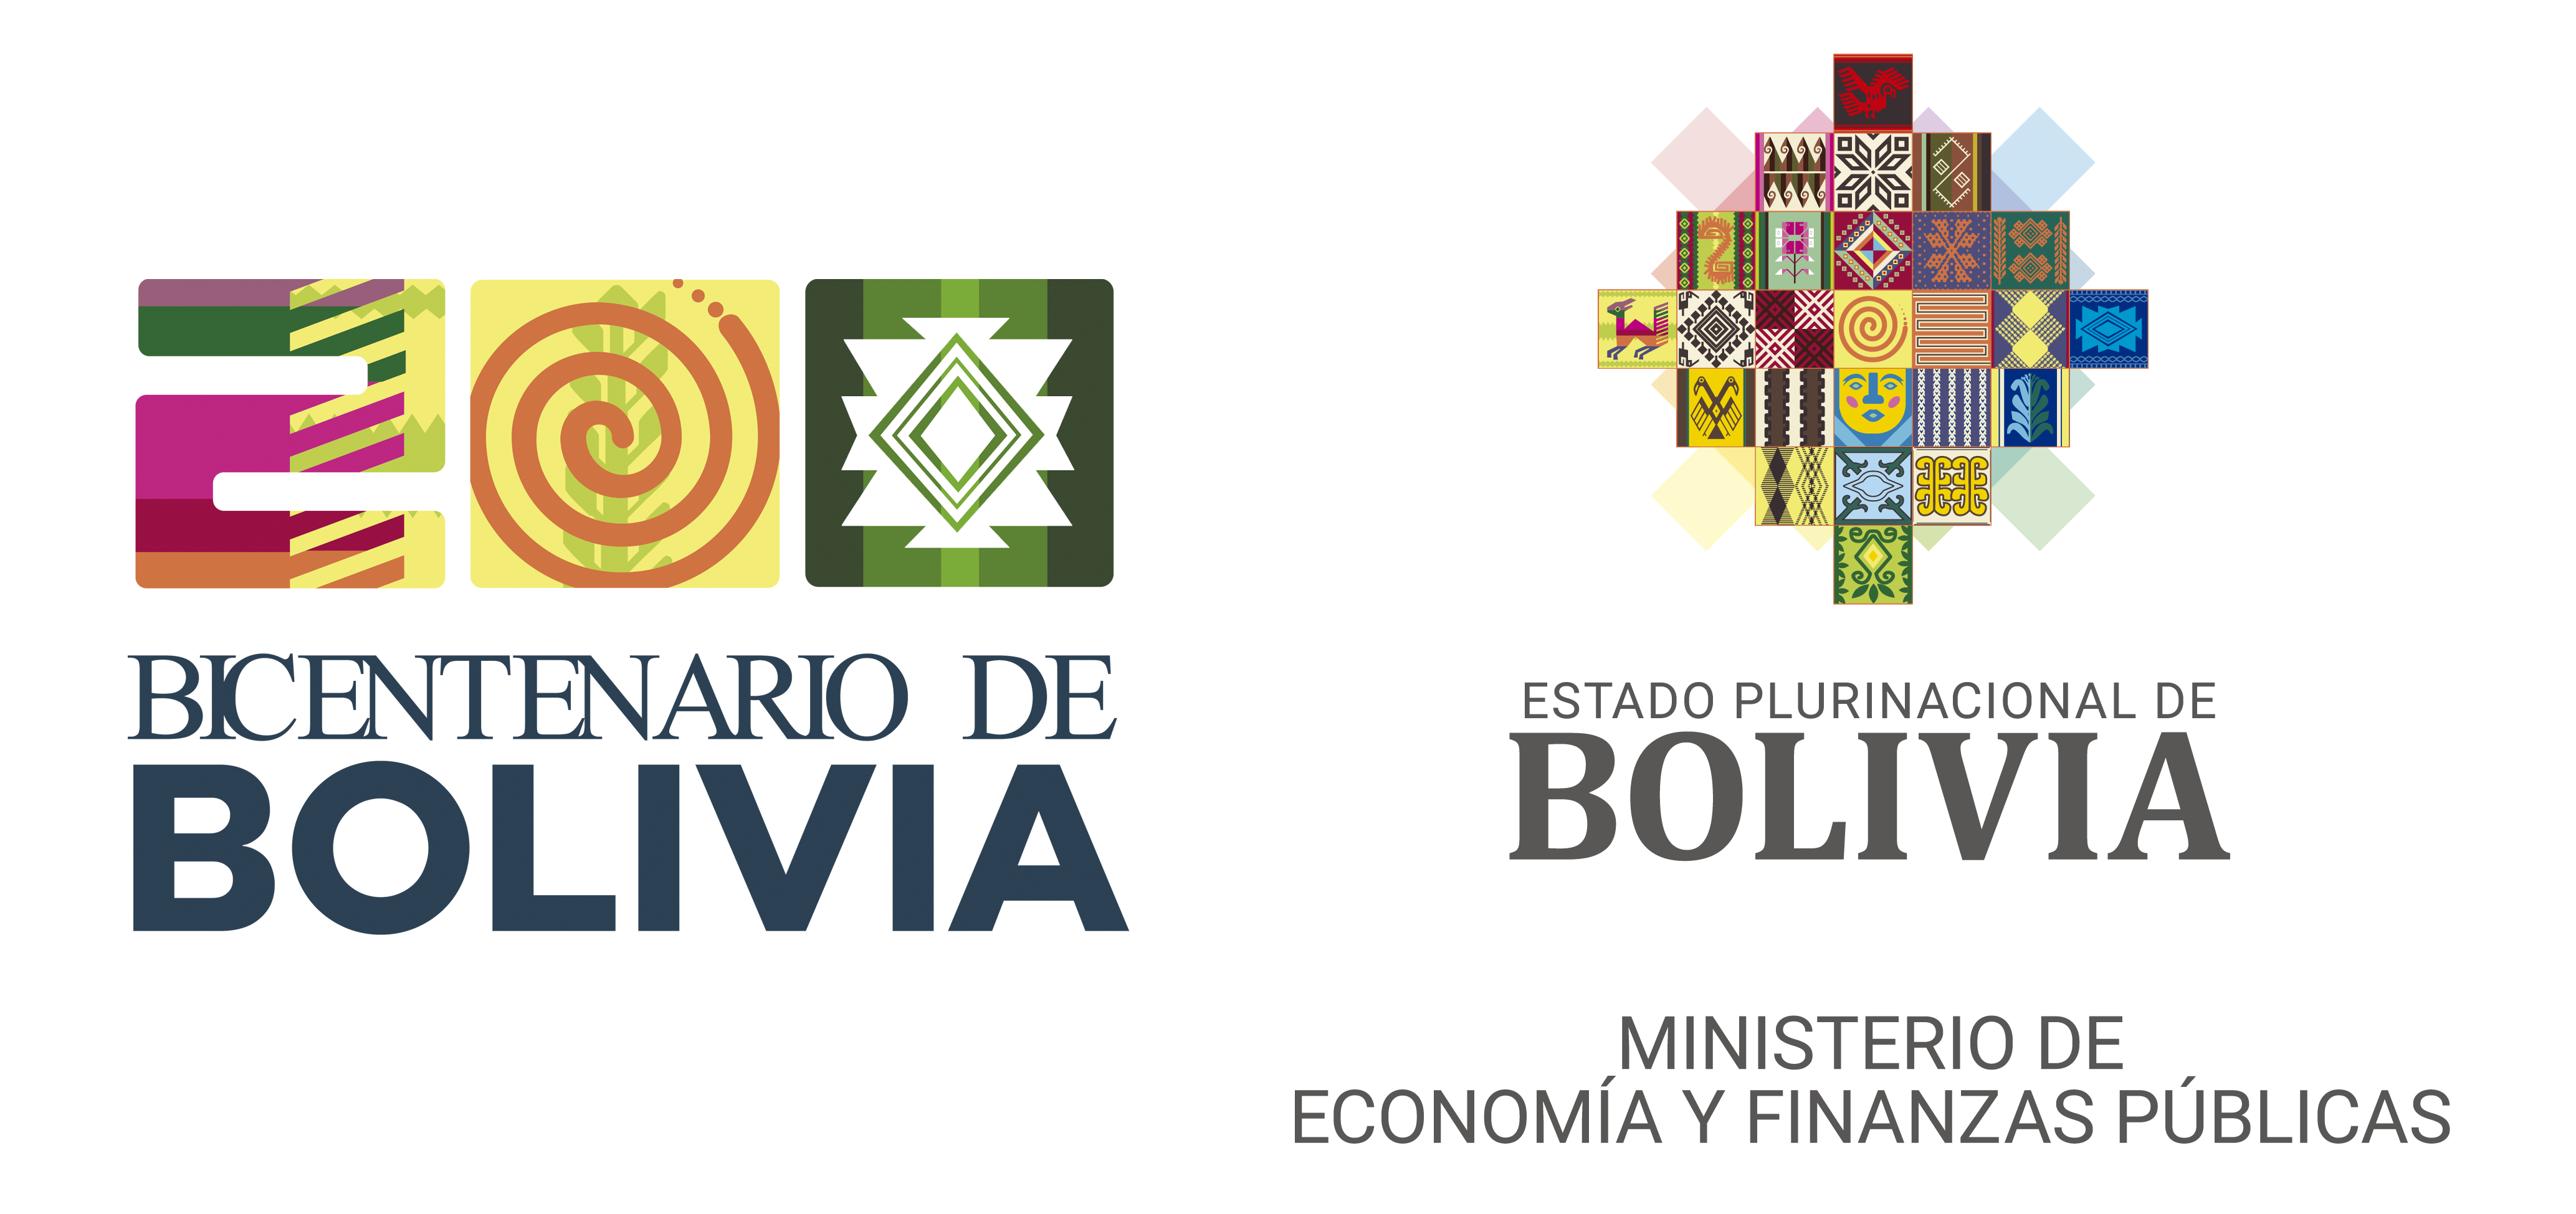

In [140]:
banner_html = """<div style="padding: 20px;display: flex;align-items: center;font-size: 21px;color: #F5FFFA;background: #A52A2A;">
    <h1> Sector Social</h1>
    </div>
    """

header = dp.Group(dp.Media("logo_web.png"), dp.HTML(banner_html), columns=2, widths=[2,5])

v = dp.View(
    #pagina uno
    dp.Page(
        header,
        dp.Select(
            dp.DataTable(df_df1T, label="Acumulada"),
            dp.DataTable(df_g1_df1T, label="Acumulada"),
            dp.DataTable(df_g12_df1T, label="A 12 meses"),
            dp.DataTable(df_d12_df1T, label="Incidencia mensual"),
            dp.DataTable(df_cumean_df1T, label="Incidencia acumulada"),
            dp.DataTable(df_gcumean_df1T, label="Incidencia a 12 meses")
            ),
          title="Tablas",
          ),
    #pagina dos
    dp.Page(
        header,
        dp.Select(
            dp.DataTable(df_dcumean_df1T, label="Ingresos"),
            dp.DataTable(df_inc1_df1_BT, label="Acumulada"),
            dp.DataTable(df_inc12_df1_BT, label="A 12 meses"),
            dp.DataTable(df_aux1, label="Incidencia mensual"),
            dp.DataTable(df_df1_CT, label="Incidencia acumulada"),
            dp.DataTable(df_df1_DT, label="Incidencia a 12 meses")
            ),
          title="Cuadros",
          ),
   #página 3
    dp.Page(
        header,
        dp.Select(
            dp.Plot(fig1, label="Población ocupada", caption="Fuente: Instituto Nacional de Estadística"),
            dp.Plot(fig2, label="PO, PEI y PD", caption="Fuente: Instituto Nacional de Estadística"),
            dp.Plot(fig3, label="Tasa desocupación urbana", caption="Fuente: Instituto Nacional de Estadística"),
            dp.Plot(fig4, label="Tasa subocupación", caption="Fuente: Instituto Nacional de Estadística"),
            dp.Plot(fig5, label="Tasa actividad", caption="Fuente: Instituto Nacional de Estadística"),
            dp.Plot(fig6, label="Tasa subocupación hombres y mujeres", caption="Fuente: Instituto Nacional de Estadística"),
            dp.Plot(fig7, label="Tasa actividad hombres y mujeres", caption="Fuente: Instituto Nacional de Estadística"),
            dp.Plot(fig8, label="Desempleo abierto", caption="Fuente: Instituto Nacional de Estadística")
            #dp.DataTable(df_egresos, label="Datos"),
            #dp.DataTable(df_egresos, label="Descripción estadistica")
            ),
          title="Graficos",
          ),

    )


dp.save_report(v, path="Dash_Social.html")
IPython.display.HTML(filename='Dash_Social.html')

## FIN